<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Resample step with MIRI imaging

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS, NIRSpec 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Create an association table for your cal files and run them through calwebb_image3](#runpipeline_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the resample step in the calwebb_image3 pipeline. At the end of the calwebb_image3 pipeline, the set of files defined in an association table will be distortion corrected and combined. Resample is the step that applies the distortion correction using the drizzling algorithm (as defined in the DrizzlePac handbook) and combines the listed files. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/resample

The data for this test were created with the MIRI Data Simulator, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Image+Combination


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator

### Description of test

This test is performed by creating a set of simulated data with multiple point sources located at specified coordinates. The simulator puts in the expected distortion, so the initial output data comes out of the simulator in distorted coordinates. When this data is then run through calwebb_detector1, calwebb_image2 and calwebbb_image3, the combined, undistorted image should have the point sources registered at the expected locations. In flight, this test can be repeated with known stars that should be found at their expected coordinates. This notebook also checks that flux values for simulated data with roughly equivalent input values show no systematic patterns after resampling. This portion of the test will only work with simulated data created for that purpose.

### Create the data for testing

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). Referring to the MIRISim link, you can see how to set up and run the simulator to re-create the input files if you wish. The data was run with a scene.ini file that specified what the scene should look like, with coordinates for the stars given in units of arcsecond offsets from the center of the field of view. The scene.ini file as well as the setup files simuation.ini and simulator.ini are needed to run the simulation.

Once in the mirisim conda environment, the simulation is run with the command line:
> mirisim simulation.ini

The simulator created four files, two exposures each at two different dither positions, using the specified filter. Make sure the WCSAXES header keyword in the SCI extension is set to 2 and not 4. If it is set to 4, change it to 2.



[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
## Run JWST Pipelines

The four files were then run individually through the calwebb_detector1 and calwebb_image2 pipelines. When running the calwebb_detector1 pipeline, increase the threshold for a detection in the jump step from 4 sigma to 10 sigma to avoid a current issue where the jump detection step flags a large percentage of pixels as jumps. This can be done on the command line. (commands to be typed start with $)

The pipelines can be run on the command line with the following commands or put into a script while using the pipeline conda environment.

$ strun calwebb_detector1.cfg filename --steps.jump.rejection_threshold 10.0

The output of the calwebb_detector1 pipeline is a set of four *rate.fits files which will then be run through the calwebb_image2 pipeline.

$ strun calwebb_image2.cfg filename

The output of the calwebb_image2 pipeline was then a set of four *cal.fits files. An association table was created that included these four files as input, and then the files and the association table were run through the calwebb_image3 pipeline. 

The cal files are stored in artifactory, and this notebook is meant to pull those files for the test of resample. Step through the cells of this notebook to run calwebb_image3 and then check the alignment.



[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp'>



<a id="imports_ID"></a>
# Imports
The following packages will need to be imported for the scripts to work.


* astropy.io for opening files
* astropy.stats for sigma clipping routine
* astropy.visualization for image plotting
* ci_watson.artifactory_helpers to read in data from artifactory
* jwst.datamodels for opening files as a JWST Datamodel
* jwst.pipeline to run the pipeline step/module
* jwst.associations to create association table
* numpy for calculations
* matplotlib.pyplot.plt to generate plot
* os for path information  
* photutils for star finding and aperture photometry
* regtest to retrieve data from artifactory needed to run notebook


[Top of Page](#title_ID)

In [2]:
from astropy.io import ascii, fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from ci_watson.artifactory_helpers import get_bigdata
import glob
from itertools import product
from jwst.datamodels import DrizProductModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import CircularAperture, DAOStarFinder, CircularAnnulus, aperture_photometry
from jwst.regtest.regtestdata import RegtestData

## Read in uncal data from artifactory 


In [3]:
print("Downloading input files")
 
#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
readnoise = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')

filelist = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 
            'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits']

for file in filelist:
    input_file = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test',
                     file)

print("Finished Downloads")


Finished Downloads


## Run Calwebb_detector1 to process files to ramp fit (slope) files

In [4]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
rej_thresh=10.0  # rejection threshold for jump step

print('There are ', len(filelist), ' images.')
    
slopelist = []    
    
# loop over list of files
for file in filelist:
    
    # set up pipeline parameters for input
    pipe1 = Detector1Pipeline()
    pipe1.jump.rejection_threshold = rej_thresh
    pipe1.jump.override_readnoise = readnoise
    pipe1.ramp_fit.override_readnoise = readnoise
    pipe1.refpix.skip = True  # needs update to simulator for this to work properly with simulated data
       
    # set up output file name
    base, remainder = file.split('.')
    outname = base
        
    pipe1.jump.output_file = outname+'.fits'    
    #pipe1.ramp_fit.output_file = outname+'.fits'
    pipe1.output_file = outname+'.fits'

    # Run pipeline on each file
    rampfile = pipe1.run(file)
    slopelist.append(rampfile)
    
    # Close the input files
    #file.close()

print('Detector 1 steps completed on all files.')
print(slopelist)

2021-07-27 02:09:53,400 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:09:53,401 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:09:53,403 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:09:53,404 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:09:53,405 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:09:53,406 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:09:53,408 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:09:53,409 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:09:53,410 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:09:53,411 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:09:53,413 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:09:53,414 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:09:53,415 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:09:53,417 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:09:53,418 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:09:53,419 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:09:53,420 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:09:53,511 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits',).


2021-07-27 02:09:53,520 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

There are  8  images.


2021-07-27 02:09:54,312 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:09:54,741 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:09:54,745 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:09:54,748 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:09:54,752 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:09:54,756 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:09:54,759 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:09:54,760 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:09:54,762 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:09:54,765 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:09:54,768 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:09:54,771 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:09:54,772 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:09:54,773 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:09:54,774 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:09:55,577 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:09:55,580 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:09:56,200 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:09:56,201 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:09:56,203 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:09:56,367 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:09:56,369 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:09:56,390 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:09:57,056 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:09:57,294 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:09:57,296 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:09:57,316 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:09:58,623 - stpipe.Detector1Pipeline.saturation - INFO - Detected 325 saturated pixels


2021-07-27 02:09:58,726 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:09:58,731 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:09:58,951 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:09:58,953 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:09:58,973 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:10:01,317 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:10:01,523 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:01,525 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:10:02,125 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:10:02,289 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:02,291 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:10:02,849 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:10:03,010 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:03,012 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:10:03,032 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:10:04,007 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:10:04,189 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:04,191 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:10:04,211 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:10:05,727 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:10:05,886 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:05,888 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:10:05,907 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:10:06,493 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:10:06,663 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:06,664 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:10:06,684 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:10:08,784 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:10:08,785 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:10:10,226 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:10:10,678 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:10,679 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:10:10,680 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:10:10,682 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:10:10,766 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:10:10,767 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:10:10,776 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:10:10,788 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:10:10,805 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:10:10,820 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:10:11,582 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:10:12,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:10:14,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3226 pixels with at least one CR and at least four groups


2021-07-27 02:10:14,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:10:14,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 27 pixels with at least one CR and two groups


2021-07-27 02:10:14,400 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:10:15,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2596 pixels with at least one CR and at least four groups


2021-07-27 02:10:15,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:10:15,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 17 pixels with at least one CR and two groups


2021-07-27 02:10:16,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:10:17,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2736 pixels with at least one CR and at least four groups


2021-07-27 02:10:17,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:10:17,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 21 pixels with at least one CR and two groups


2021-07-27 02:10:17,670 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.08708 sec


2021-07-27 02:10:17,673 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.897011


2021-07-27 02:10:18,192 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits


2021-07-27 02:10:18,193 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:10:18,340 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:10:18,341 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:10:18,362 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:10:18,377 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:10:18,392 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:10:18,393 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:10:18,409 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:10:18,410 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:11:13,154 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:11:13,157 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:11:13,305 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:11:13,504 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:11:13,506 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:13,544 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:11:13,545 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:11:13,548 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:11:13,626 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:11:13,628 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:13,659 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:11:13,660 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:11:13,662 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:11:13,772 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rateints.fits


2021-07-27 02:11:13,775 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:11:13,838 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits


2021-07-27 02:11:13,839 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:11:13,857 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:11:13,859 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:11:13,860 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:11:13,861 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:11:13,863 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:11:13,864 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:11:13,865 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:11:13,866 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:11:13,868 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:11:13,869 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:11:13,870 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:11:13,871 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:11:13,872 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:11:13,874 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:11:13,875 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:11:13,876 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:11:13,882 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:11:14,112 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',).


2021-07-27 02:11:14,123 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:11:14,623 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:11:14,632 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:11:14,634 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:11:14,635 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:11:14,637 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:11:14,638 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:11:14,640 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:11:14,641 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:11:14,641 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:11:14,643 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:11:14,645 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:11:14,646 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:11:14,647 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:11:14,647 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:11:14,648 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:11:15,297 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:15,299 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:15,827 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:11:15,828 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:11:15,830 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:11:15,909 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:15,911 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:15,929 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:11:16,519 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:11:16,666 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:16,668 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:16,687 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:11:17,840 - stpipe.Detector1Pipeline.saturation - INFO - Detected 325 saturated pixels


2021-07-27 02:11:17,917 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:11:17,922 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:11:18,073 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:18,075 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:18,095 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:11:20,174 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:11:20,328 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:20,330 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:20,865 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:11:21,025 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:21,027 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:21,622 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:11:21,770 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:21,771 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:21,791 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:11:22,659 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:11:22,823 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:22,825 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:11:22,844 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:11:24,265 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:11:24,421 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:24,422 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:11:24,441 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:11:25,029 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:11:25,181 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:25,183 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:11:25,202 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:11:26,949 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:11:26,950 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:11:28,337 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:11:28,749 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:28,751 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:11:28,751 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:11:28,753 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:11:28,832 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:11:28,833 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:11:28,842 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:11:28,854 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:11:28,869 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:11:28,884 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:11:29,648 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:11:30,794 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:11:32,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3134 pixels with at least one CR and at least four groups


2021-07-27 02:11:32,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:11:32,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 32 pixels with at least one CR and two groups


2021-07-27 02:11:32,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:11:33,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2891 pixels with at least one CR and at least four groups


2021-07-27 02:11:33,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:11:33,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 20 pixels with at least one CR and two groups


2021-07-27 02:11:34,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:11:35,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2790 pixels with at least one CR and at least four groups


2021-07-27 02:11:35,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:11:35,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 23 pixels with at least one CR and two groups


2021-07-27 02:11:35,723 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.07392 sec


2021-07-27 02:11:35,726 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.883984


2021-07-27 02:11:36,244 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits


2021-07-27 02:11:36,245 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:11:36,377 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:11:36,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:11:36,399 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:11:36,414 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:11:36,429 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:11:36,430 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:11:36,446 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:11:36,448 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:12:29,564 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:12:29,565 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:12:29,668 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:12:29,836 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:12:29,838 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:29,875 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:12:29,876 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:12:29,879 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:12:29,966 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:12:29,968 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:30,000 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:12:30,001 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:12:30,003 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:12:30,108 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rateints.fits


2021-07-27 02:12:30,110 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:12:30,172 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits


2021-07-27 02:12:30,173 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:12:30,181 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:12:30,183 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:12:30,184 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:12:30,186 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:12:30,187 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:12:30,188 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:12:30,189 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:12:30,190 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:12:30,191 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:12:30,192 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:12:30,193 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:12:30,194 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:12:30,195 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:12:30,197 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:12:30,198 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:12:30,199 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:12:30,200 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:12:30,358 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',).


2021-07-27 02:12:30,369 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:12:30,844 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:12:30,855 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:12:30,857 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:12:30,859 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:12:30,860 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:12:30,862 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:12:30,864 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:12:30,864 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:12:30,865 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:12:30,867 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:12:30,869 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:12:30,871 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:12:30,871 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:12:30,872 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:12:30,872 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:12:31,504 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:31,506 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:32,029 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:12:32,031 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:12:32,032 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:12:32,110 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:32,112 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:32,131 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:12:32,716 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:12:32,861 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:32,863 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:32,882 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:12:34,025 - stpipe.Detector1Pipeline.saturation - INFO - Detected 334 saturated pixels


2021-07-27 02:12:34,099 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:12:34,104 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:12:34,240 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:34,242 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:34,261 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:12:36,322 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:12:36,468 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:36,470 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:36,993 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:12:37,129 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:37,131 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:37,665 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:12:37,810 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:37,812 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:37,832 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:12:38,668 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:12:38,831 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:38,833 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:12:38,852 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:12:40,244 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:12:40,386 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:40,388 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:12:40,407 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:12:40,954 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:12:41,104 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:41,106 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:12:41,125 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:12:42,851 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:12:42,852 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:12:44,220 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:12:44,611 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:44,613 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:12:44,614 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:12:44,615 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:12:44,694 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:12:44,696 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:12:44,704 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:12:44,716 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:12:44,731 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:12:44,746 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:12:45,472 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:12:46,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:12:48,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3083 pixels with at least one CR and at least four groups


2021-07-27 02:12:48,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:12:48,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-07-27 02:12:48,215 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:12:49,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2806 pixels with at least one CR and at least four groups


2021-07-27 02:12:49,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:12:49,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 27 pixels with at least one CR and two groups


2021-07-27 02:12:49,785 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:12:51,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2541 pixels with at least one CR and at least four groups


2021-07-27 02:12:51,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:12:51,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-07-27 02:12:51,399 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.92566 sec


2021-07-27 02:12:51,401 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.697278


2021-07-27 02:12:51,899 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits


2021-07-27 02:12:51,900 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:12:52,035 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:12:52,037 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:12:52,057 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:12:52,072 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:12:52,086 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:12:52,087 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:12:52,103 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:12:52,105 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:13:45,149 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:13:45,150 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:13:45,249 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:13:45,415 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:13:45,417 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:45,458 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:13:45,459 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:13:45,461 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:13:45,539 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:13:45,540 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:45,571 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:13:45,572 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:13:45,574 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:13:45,680 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rateints.fits


2021-07-27 02:13:45,681 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:13:45,740 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits


2021-07-27 02:13:45,741 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:13:45,749 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:13:45,751 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:13:45,752 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:13:45,753 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:13:45,754 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:13:45,755 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:13:45,757 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:13:45,758 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:13:45,759 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:13:45,760 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:13:45,762 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:13:45,763 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:13:45,764 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:13:45,765 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:13:45,766 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:13:45,768 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:13:45,769 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:13:45,924 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',).


2021-07-27 02:13:45,934 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:13:46,423 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:13:46,431 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:13:46,433 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:13:46,434 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:13:46,436 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:13:46,438 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:13:46,440 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:13:46,441 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:13:46,441 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:13:46,444 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:13:46,445 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:13:46,447 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:13:46,448 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:13:46,448 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:13:46,449 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:13:47,099 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:47,101 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:47,627 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:13:47,628 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:13:47,629 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:13:47,708 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:47,710 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:47,728 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:13:48,304 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:13:48,450 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:48,451 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:48,470 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:13:49,632 - stpipe.Detector1Pipeline.saturation - INFO - Detected 335 saturated pixels


2021-07-27 02:13:49,715 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:13:49,720 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:13:49,856 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:49,858 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:49,878 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:13:52,029 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:13:52,174 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:52,176 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:52,699 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:13:52,836 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:52,838 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:53,375 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:13:53,519 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:53,521 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:53,540 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:13:54,369 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:13:54,532 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:54,534 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:13:54,554 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:13:55,953 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:13:56,094 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:56,096 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:13:56,115 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:13:56,666 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:13:56,810 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:13:56,812 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:13:56,831 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:13:58,550 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:13:58,551 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:13:59,889 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:14:00,275 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:14:00,277 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:14:00,278 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:14:00,280 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:14:00,358 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:14:00,360 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:14:00,368 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:14:00,380 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:14:00,394 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:14:00,409 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:14:01,176 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:14:02,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:14:03,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3074 pixels with at least one CR and at least four groups


2021-07-27 02:14:03,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:14:03,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31 pixels with at least one CR and two groups


2021-07-27 02:14:03,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:14:05,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2830 pixels with at least one CR and at least four groups


2021-07-27 02:14:05,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:14:05,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 19 pixels with at least one CR and two groups


2021-07-27 02:14:05,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:14:06,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2628 pixels with at least one CR and at least four groups


2021-07-27 02:14:06,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:14:06,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-07-27 02:14:07,080 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 5.90252 sec


2021-07-27 02:14:07,082 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.714359


2021-07-27 02:14:07,578 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits


2021-07-27 02:14:07,579 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:14:07,717 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:14:07,719 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:14:07,739 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:14:07,754 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:14:07,768 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:14:07,769 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:14:07,785 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:14:07,787 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:15:04,963 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:15:04,966 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:15:05,105 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:15:05,388 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:15:05,390 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:05,430 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:15:05,431 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:15:05,434 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:15:05,601 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:15:05,603 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:05,639 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:15:05,640 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:15:05,644 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:15:05,768 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rateints.fits


2021-07-27 02:15:05,770 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:15:05,836 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits


2021-07-27 02:15:05,838 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:15:05,848 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:15:05,850 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:15:05,851 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:15:05,853 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:15:05,855 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:15:05,856 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:15:05,858 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:15:05,860 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:15:05,861 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:15:05,863 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:15:05,866 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:15:05,868 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:15:05,870 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:15:05,872 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:15:05,874 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:15:05,875 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:15:05,878 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:15:06,151 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',).


2021-07-27 02:15:06,162 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:15:06,700 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:15:06,710 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:15:06,713 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:15:06,715 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:15:06,718 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:15:06,720 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:15:06,723 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:15:06,724 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:15:06,725 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:15:06,727 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:15:06,729 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:15:06,731 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:15:06,733 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:15:06,733 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:15:06,734 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:15:07,507 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:07,510 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:08,067 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:15:08,069 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:15:08,071 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:15:08,236 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:08,239 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:08,261 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:15:08,903 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:15:09,146 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:09,148 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:09,170 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:15:10,408 - stpipe.Detector1Pipeline.saturation - INFO - Detected 289 saturated pixels


2021-07-27 02:15:10,495 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:15:10,501 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:15:10,745 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:10,748 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:10,770 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:15:13,003 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:15:13,247 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:13,249 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:13,815 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:15:14,068 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:14,070 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:14,693 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:15:14,936 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:14,938 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:14,959 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:15:15,818 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:15:16,091 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:16,093 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:15:16,115 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:15:17,748 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:15:17,988 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:17,991 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:15:18,012 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:15:18,606 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:15:18,851 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:18,853 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:15:18,874 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:15:20,944 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:15:20,945 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:15:22,419 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:15:22,972 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:22,974 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:15:22,975 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:15:22,978 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:15:23,080 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:15:23,082 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:15:23,093 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:15:23,106 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:15:23,123 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:15:23,138 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:15:23,991 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:15:25,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:15:26,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2830 pixels with at least one CR and at least four groups


2021-07-27 02:15:26,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:15:26,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 35 pixels with at least one CR and two groups


2021-07-27 02:15:27,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:15:28,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2423 pixels with at least one CR and at least four groups


2021-07-27 02:15:28,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:15:28,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 30 pixels with at least one CR and two groups


2021-07-27 02:15:29,027 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:15:30,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2603 pixels with at least one CR and at least four groups


2021-07-27 02:15:30,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:15:30,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 26 pixels with at least one CR and two groups


2021-07-27 02:15:30,959 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.96584 sec


2021-07-27 02:15:30,969 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.875970


2021-07-27 02:15:32,251 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits


2021-07-27 02:15:32,254 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:15:32,537 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:15:32,539 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:15:32,559 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:15:32,579 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:15:32,598 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:15:32,599 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:15:32,627 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:15:32,629 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:16:27,514 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:16:27,516 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:16:27,629 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:16:27,829 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:16:27,832 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:27,876 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:16:27,877 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:16:27,879 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:16:27,973 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:16:27,974 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:28,009 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:16:28,010 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:16:28,013 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:16:28,114 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rateints.fits


2021-07-27 02:16:28,116 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:16:28,177 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits


2021-07-27 02:16:28,178 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:16:28,186 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:16:28,187 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:16:28,188 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:16:28,190 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:16:28,191 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:16:28,192 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:16:28,196 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:16:28,199 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:16:28,201 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:16:28,204 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:16:28,208 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:16:28,210 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:16:28,211 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:16:28,213 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:16:28,215 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:16:28,217 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:16:28,218 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:16:28,378 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',).


2021-07-27 02:16:28,388 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:16:28,881 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:16:28,892 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:16:28,894 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:16:28,896 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:16:28,897 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:16:28,900 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:16:28,902 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:16:28,902 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:16:28,903 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:16:28,906 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:16:28,908 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:16:28,910 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:16:28,910 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:16:28,911 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:16:28,911 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:16:29,554 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:29,556 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:30,124 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:16:30,125 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:16:30,127 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:16:30,207 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:30,209 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:30,228 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:16:30,849 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:16:31,004 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:31,006 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:31,025 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:16:32,205 - stpipe.Detector1Pipeline.saturation - INFO - Detected 289 saturated pixels


2021-07-27 02:16:32,283 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:16:32,288 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:16:32,450 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:32,452 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:32,471 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:16:34,609 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:16:34,764 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:34,766 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:35,330 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:16:35,490 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:35,492 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:36,071 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:16:36,226 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:36,227 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:36,247 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:16:37,086 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:16:37,279 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:37,281 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:16:37,300 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:16:38,746 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:16:38,901 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:38,903 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:16:38,922 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:16:39,506 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:16:39,667 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:39,669 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:16:39,688 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:16:41,958 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:16:41,959 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:16:43,366 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:16:43,832 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:43,834 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:16:43,835 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:16:43,836 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:16:43,918 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:16:43,919 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:16:43,928 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:16:43,940 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:16:43,956 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:16:43,972 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:16:44,730 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:16:45,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:16:47,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 3028 pixels with at least one CR and at least four groups


2021-07-27 02:16:47,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:16:47,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 34 pixels with at least one CR and two groups


2021-07-27 02:16:47,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:16:49,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2351 pixels with at least one CR and at least four groups


2021-07-27 02:16:49,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:16:49,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 21 pixels with at least one CR and two groups


2021-07-27 02:16:49,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:16:50,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2475 pixels with at least one CR and at least four groups


2021-07-27 02:16:50,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:16:50,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-07-27 02:16:50,914 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.18312 sec


2021-07-27 02:16:50,917 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.988955


2021-07-27 02:16:51,431 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits


2021-07-27 02:16:51,432 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:16:51,587 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:16:51,589 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:16:51,609 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:16:51,625 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:16:51,641 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:16:51,642 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:16:51,659 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:16:51,660 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:17:45,499 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:17:45,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:17:45,610 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:17:45,794 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:17:45,796 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:45,834 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:17:45,835 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:17:45,837 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:17:45,919 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:17:45,921 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:45,953 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:17:45,954 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:17:45,956 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:17:46,061 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rateints.fits


2021-07-27 02:17:46,062 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:17:46,122 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits


2021-07-27 02:17:46,123 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:17:46,131 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:17:46,132 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:17:46,133 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:17:46,135 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:17:46,136 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:17:46,137 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:17:46,139 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:17:46,140 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:17:46,141 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:17:46,142 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:17:46,143 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:17:46,145 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:17:46,146 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:17:46,147 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:17:46,149 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:17:46,150 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:17:46,151 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:17:46,315 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',).


2021-07-27 02:17:46,325 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:17:46,825 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:17:46,833 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:17:46,836 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:17:46,837 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:17:46,839 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:17:46,841 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:17:46,843 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:17:46,844 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:17:46,845 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:17:46,847 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:17:46,849 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:17:46,851 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:17:46,851 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:17:46,852 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:17:46,852 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:17:47,522 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:47,524 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:48,106 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:17:48,107 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:17:48,108 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:17:48,189 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:48,190 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:48,209 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:17:48,817 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:17:48,973 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:48,974 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:48,993 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:17:50,183 - stpipe.Detector1Pipeline.saturation - INFO - Detected 297 saturated pixels


2021-07-27 02:17:50,260 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:17:50,266 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:17:50,420 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:50,422 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:50,441 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:17:52,570 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:17:52,726 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:52,728 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:53,295 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:17:53,449 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:53,451 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:54,019 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:17:54,172 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:54,174 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:54,194 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:17:55,041 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:17:55,220 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:55,222 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:17:55,241 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:17:56,654 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:17:56,810 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:56,811 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:17:56,830 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:17:57,496 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:17:57,655 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:17:57,657 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:17:57,676 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:17:59,912 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:17:59,913 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:18:01,367 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:18:01,823 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:18:01,824 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:18:01,825 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:18:01,827 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:18:01,907 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2021-07-27 02:18:01,909 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:18:01,918 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:18:01,929 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:18:01,945 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:18:01,960 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:18:02,715 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:18:03,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:18:05,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2808 pixels with at least one CR and at least four groups


2021-07-27 02:18:05,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:18:05,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 36 pixels with at least one CR and two groups


2021-07-27 02:18:05,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:18:06,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2452 pixels with at least one CR and at least four groups


2021-07-27 02:18:06,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:18:06,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 31 pixels with at least one CR and two groups


2021-07-27 02:18:07,101 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:18:08,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2748 pixels with at least one CR and at least four groups


2021-07-27 02:18:08,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:18:08,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 25 pixels with at least one CR and two groups


2021-07-27 02:18:08,768 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.05136 sec


2021-07-27 02:18:08,770 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.852774


2021-07-27 02:18:09,274 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits


2021-07-27 02:18:09,275 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:18:09,431 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:18:09,432 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:18:09,452 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:18:09,468 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:18:09,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:18:09,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:18:09,501 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:18:09,503 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:19:04,482 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:19:04,484 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:19:04,592 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:19:04,779 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:19:04,781 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:04,821 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:19:04,822 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:19:04,824 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:19:04,904 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_jump.fits>,).


2021-07-27 02:19:04,905 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:04,938 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:19:04,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:19:04,941 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:19:05,045 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rateints.fits


2021-07-27 02:19:05,047 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:19:05,107 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits


2021-07-27 02:19:05,108 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2021-07-27 02:19:05,115 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2021-07-27 02:19:05,117 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2021-07-27 02:19:05,118 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2021-07-27 02:19:05,119 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2021-07-27 02:19:05,121 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2021-07-27 02:19:05,122 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2021-07-27 02:19:05,123 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2021-07-27 02:19:05,124 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2021-07-27 02:19:05,126 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2021-07-27 02:19:05,127 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2021-07-27 02:19:05,128 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2021-07-27 02:19:05,129 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2021-07-27 02:19:05,131 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2021-07-27 02:19:05,132 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2021-07-27 02:19:05,133 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2021-07-27 02:19:05,135 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2021-07-27 02:19:05,136 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2021-07-27 02:19:05,297 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits',).


2021-07-27 02:19:05,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': 

2021-07-27 02:19:05,847 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2021-07-27 02:19:05,855 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2021-07-27 02:19:05,857 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2021-07-27 02:19:05,858 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2021-07-27 02:19:05,860 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2021-07-27 02:19:05,862 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits'.


2021-07-27 02:19:05,863 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2021-07-27 02:19:05,864 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits'.


2021-07-27 02:19:05,865 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2021-07-27 02:19:05,866 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits'.


2021-07-27 02:19:05,868 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2021-07-27 02:19:05,870 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2021-07-27 02:19:05,871 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2021-07-27 02:19:05,871 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2021-07-27 02:19:05,872 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2021-07-27 02:19:06,544 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:06,546 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:07,102 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2021-07-27 02:19:07,103 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2021-07-27 02:19:07,104 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2021-07-27 02:19:07,185 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:07,186 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:07,205 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0023.fits


2021-07-27 02:19:07,834 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2021-07-27 02:19:07,986 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:07,988 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:08,007 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2021-07-27 02:19:09,167 - stpipe.Detector1Pipeline.saturation - INFO - Detected 299 saturated pixels


2021-07-27 02:19:09,243 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2021-07-27 02:19:09,248 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2021-07-27 02:19:09,401 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:09,403 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:09,421 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2021-07-27 02:19:11,583 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2021-07-27 02:19:11,739 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:11,741 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:12,299 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2021-07-27 02:19:12,457 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:12,460 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:13,049 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2021-07-27 02:19:13,220 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:13,222 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:13,241 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2021-07-27 02:19:14,074 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2021-07-27 02:19:14,258 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:14,260 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:19:14,279 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2021-07-27 02:19:15,658 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2021-07-27 02:19:15,810 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:15,812 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2021-07-27 02:19:15,831 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0010.fits


2021-07-27 02:19:16,408 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2021-07-27 02:19:16,563 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:16,565 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2021-07-27 02:19:16,584 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2021-07-27 02:19:18,850 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2021-07-27 02:19:18,851 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2021-07-27 02:19:20,252 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2021-07-27 02:19:20,717 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:20,719 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2021-07-27 02:19:20,720 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2021-07-27 02:19:20,721 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2021-07-27 02:19:20,802 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits>,).


2021-07-27 02:19:20,804 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2021-07-27 02:19:20,813 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2021-07-27 02:19:20,825 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:19:20,842 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:19:20,857 - stpipe.Detector1Pipeline.jump - INFO - Using 1 core for jump detection 


2021-07-27 02:19:21,618 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2021-07-27 02:19:22,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2021-07-27 02:19:24,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2808 pixels with at least one CR and at least four groups


2021-07-27 02:19:24,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:19:24,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 37 pixels with at least one CR and two groups


2021-07-27 02:19:24,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2021-07-27 02:19:25,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2620 pixels with at least one CR and at least four groups


2021-07-27 02:19:25,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:19:25,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-07-27 02:19:26,035 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2021-07-27 02:19:27,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 2623 pixels with at least one CR and at least four groups


2021-07-27 02:19:27,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 0 pixels with at least one CR and three groups


2021-07-27 02:19:27,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 28 pixels with at least one CR and two groups


2021-07-27 02:19:27,716 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.09682 sec


2021-07-27 02:19:27,719 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 6.905875


2021-07-27 02:19:28,224 - stpipe.Detector1Pipeline.jump - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits


2021-07-27 02:19:28,225 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2021-07-27 02:19:28,380 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:19:28,382 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


2021-07-27 02:19:28,402 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/jwst_mirisim_readnoise.fits


2021-07-27 02:19:28,418 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2021-07-27 02:19:28,433 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2021-07-27 02:19:28,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2021-07-27 02:19:28,450 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2021-07-27 02:19:28,452 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2021-07-27 02:20:21,814 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2021-07-27 02:20:21,816 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2021-07-27 02:20:21,925 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2021-07-27 02:20:22,108 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:20:22,110 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:20:22,151 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:20:22,152 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:20:22,154 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:20:22,236 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_jump.fits>,).


2021-07-27 02:20:22,238 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2021-07-27 02:20:22,270 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2021-07-27 02:20:22,271 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2021-07-27 02:20:22,273 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2021-07-27 02:20:22,378 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rateints.fits


2021-07-27 02:20:22,379 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2021-07-27 02:20:22,440 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits


2021-07-27 02:20:22,441 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Detector 1 steps completed on all files.
[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>]


## Run Calwebb_image2 on files output from detector1 to create calibrated individual images

In [5]:
# Run Calwebb_image2 on output files from detector1
    
print('There are ', len(slopelist), ' images.')
    
callist = []

# cycle through files
for rampfile in slopelist:
    
    # create an object for the pipeline    
    pipe2 = Image2Pipeline()

    filename = rampfile.meta.filename
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)

print(callist)


2021-07-27 02:20:22,456 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:22,458 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:22,460 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:22,461 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:22,463 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:22,464 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:22,627 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:22,632 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:22,640 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


There are  8  images.


2021-07-27 02:20:22,649 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:22,651 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:22,652 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:22,652 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:22,653 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:22,653 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:22,655 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:22,657 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:22,658 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:22,660 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:22,662 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:22,663 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:22,663 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:22,664 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:22,665 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:22,665 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:22,666 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:22,666 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:22,668 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:22,668 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:22,669 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:22,669 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:22,670 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:22,670 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:22,739 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:22,740 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-07-27 02:20:22,829 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:22,830 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:23,018 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:23,073 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:23,078 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-07-27 02:20:23,078 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-07-27 02:20:23,079 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:23,113 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:23,164 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:23,249 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:23,251 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:23,348 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:23,349 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:23,350 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:23,357 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:23,448 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:23,537 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:23,538 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:23,563 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:23,564 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:23,626 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:23,627 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:23,628 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:23,628 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:23,664 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:23,666 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:23,667 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:23,676 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:23,762 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:23,764 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:23,787 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:23,888 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:24,495 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:24,923 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:25,469 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:25,899 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:20:26,445 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:26,875 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:20:27,421 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:27,859 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:27,861 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358646 -0.016334386 0.022108876 0.015005126 359.990738698 0.017758047 359.987988468 -0.013581465


2021-07-27 02:20:27,957 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits


2021-07-27 02:20:27,958 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:20:27,959 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:27,960 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:20:28,089 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits


2021-07-27 02:20:28,090 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:20:28,095 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:28,097 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:28,098 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:28,100 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:28,101 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:28,102 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:28,190 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:28,194 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:28,201 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:20:28,205 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:28,208 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:28,208 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:28,209 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:28,210 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:28,210 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:28,212 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:28,213 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:28,214 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:28,215 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:28,216 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:28,216 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:28,216 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:28,217 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:28,217 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:28,218 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:28,218 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:28,218 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:28,220 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:28,220 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:28,220 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:28,221 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:28,221 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:28,221 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:28,286 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:20:28,287 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-07-27 02:20:28,377 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:28,379 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:28,543 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:28,590 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:28,594 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-07-27 02:20:28,595 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-07-27 02:20:28,596 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:28,629 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:28,678 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:28,769 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:28,770 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:28,860 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:28,861 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:28,862 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:28,869 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:28,962 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:29,055 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:29,057 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:29,080 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:29,081 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:29,143 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:29,144 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:29,145 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:29,145 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:29,175 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:29,177 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:29,177 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:29,186 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:29,274 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:29,276 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:29,299 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:29,396 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:29,970 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:30,406 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:30,960 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:31,393 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:20:31,960 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:32,391 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:20:32,949 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:33,390 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:33,392 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358646 -0.016334386 0.022108876 0.015005126 359.990738698 0.017758047 359.987988468 -0.013581465


2021-07-27 02:20:33,494 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits


2021-07-27 02:20:33,495 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:20:33,496 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:20:33,497 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:20:33,632 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits


2021-07-27 02:20:33,633 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:20:33,646 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:33,648 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:33,650 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:33,652 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:33,654 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:33,656 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:33,771 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:33,775 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:33,782 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:20:33,786 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:33,789 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:33,789 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:33,790 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:33,790 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:33,791 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:33,792 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:33,793 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:33,794 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:33,795 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:33,796 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:33,797 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:33,797 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:33,798 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:33,798 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:33,799 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:33,799 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:33,800 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:33,801 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:33,801 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:33,801 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:33,802 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:33,802 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:33,802 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:33,864 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:33,865 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-07-27 02:20:33,960 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:33,962 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:34,133 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:34,181 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:34,185 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-07-27 02:20:34,186 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-07-27 02:20:34,187 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:34,221 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:34,270 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:34,362 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:34,363 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:34,461 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:34,462 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:34,463 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:34,470 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:34,564 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:34,659 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:34,660 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:34,685 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:34,686 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:34,750 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:34,751 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:34,752 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:34,753 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:34,784 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:34,786 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:34,787 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:34,795 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:34,884 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:34,886 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:34,909 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:35,007 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:35,557 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:35,991 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:36,536 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:36,965 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:20:37,515 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:37,944 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:20:38,488 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:38,925 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:38,927 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997794 -0.017656179 0.022748024 0.013683333 359.991377847 0.016436254 359.988627617 -0.014903258


2021-07-27 02:20:39,023 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits


2021-07-27 02:20:39,024 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:20:39,025 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:39,027 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:20:39,156 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits


2021-07-27 02:20:39,157 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:20:39,161 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:39,163 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:39,164 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:39,166 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:39,167 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:39,168 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:39,264 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:39,269 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:39,276 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:20:39,279 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:39,282 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:39,283 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:39,283 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:39,284 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:39,284 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:39,286 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:39,287 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:39,287 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:39,289 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:39,290 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:39,291 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:39,291 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:39,292 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:39,292 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:39,293 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:39,293 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:39,293 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:39,295 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:39,295 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:39,296 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:39,296 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:39,296 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:39,297 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:39,371 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:20:39,372 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-07-27 02:20:39,466 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:39,468 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:39,633 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:39,680 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:39,684 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-07-27 02:20:39,685 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-07-27 02:20:39,685 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:39,719 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:39,768 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:39,863 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:39,864 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:39,958 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:39,959 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:39,960 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:39,967 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:40,060 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:40,155 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:40,157 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:40,181 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:40,182 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:40,244 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:40,245 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:40,246 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:40,246 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:40,276 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:40,278 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:40,279 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:40,288 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:40,380 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:40,381 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:40,404 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:40,501 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:41,062 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:41,490 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:42,079 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:42,510 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:20:43,089 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:43,517 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:20:44,100 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:44,536 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:44,539 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997794 -0.017656179 0.022748024 0.013683333 359.991377847 0.016436254 359.988627617 -0.014903258


2021-07-27 02:20:44,635 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits


2021-07-27 02:20:44,636 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:20:44,637 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:20:44,638 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:20:44,769 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits


2021-07-27 02:20:44,770 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:20:44,775 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:44,776 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:44,777 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:44,779 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:44,780 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:44,781 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:44,875 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:44,879 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:44,886 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:20:44,890 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:44,893 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:44,893 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:44,894 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:44,894 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:44,895 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:44,896 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:44,897 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:44,898 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:44,899 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:44,900 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:44,901 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:44,901 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:44,902 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:44,902 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:44,902 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:44,903 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:44,903 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:44,904 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:44,904 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:44,905 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:44,905 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:44,905 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:44,906 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:44,940 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:44,941 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-07-27 02:20:45,033 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:45,035 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:45,203 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:45,250 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:45,254 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-07-27 02:20:45,255 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-07-27 02:20:45,256 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:45,289 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:45,337 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:45,431 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:45,433 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:45,523 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:45,524 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:45,525 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:45,532 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:45,624 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:45,719 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:45,721 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:45,745 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:45,746 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:45,809 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:45,810 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:45,810 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:45,811 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:45,842 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:45,843 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:45,844 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:45,853 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:45,948 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:45,950 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:45,973 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:46,070 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:46,672 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:47,099 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:47,724 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:48,153 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:20:48,758 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:49,192 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:20:49,795 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:50,233 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:50,235 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228939 -0.020106952 0.022979169 0.011232559 359.991608992 0.013985480 359.988858761 -0.017354031


2021-07-27 02:20:50,332 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits


2021-07-27 02:20:50,333 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:20:50,334 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:50,335 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:20:50,466 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits


2021-07-27 02:20:50,467 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:20:50,472 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:50,473 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:50,474 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:50,476 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:50,477 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:50,479 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:50,574 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:50,579 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:50,586 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:20:50,590 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:50,592 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:50,593 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:50,594 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:50,594 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:50,595 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:50,596 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:50,597 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:50,598 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:50,600 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:50,601 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:50,601 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:50,601 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:50,602 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:50,602 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:50,603 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:50,603 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:50,603 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:50,604 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:50,605 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:50,605 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:50,606 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:50,606 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:50,606 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:50,641 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:20:50,642 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-07-27 02:20:50,737 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:50,739 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:50,904 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:50,951 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:50,955 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-07-27 02:20:50,956 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-07-27 02:20:50,957 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:50,990 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:51,038 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:51,131 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:51,132 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:51,223 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:51,224 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:51,225 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:51,231 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:51,324 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:51,419 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:51,421 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:51,445 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:51,446 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:51,508 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:51,509 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:51,510 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:51,510 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:51,540 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:51,542 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:51,543 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:51,551 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:51,644 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:20:51,646 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:51,669 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:51,765 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:52,372 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:52,799 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:53,446 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:53,881 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:20:54,545 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:54,980 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:20:55,619 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:56,056 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:56,058 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228939 -0.020106952 0.022979169 0.011232559 359.991608992 0.013985480 359.988858761 -0.017354031


2021-07-27 02:20:56,154 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits


2021-07-27 02:20:56,155 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:20:56,156 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:20:56,157 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:20:56,288 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits


2021-07-27 02:20:56,289 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:20:56,293 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:20:56,295 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:20:56,296 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:20:56,298 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:20:56,299 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:20:56,300 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:20:56,396 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:56,401 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:20:56,408 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:20:56,411 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:20:56,414 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:20:56,414 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:20:56,415 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:20:56,416 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:20:56,416 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:20:56,418 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:20:56,419 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:20:56,419 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:20:56,420 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:20:56,422 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:20:56,422 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:20:56,423 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:20:56,423 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:20:56,423 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:20:56,424 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:20:56,424 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:20:56,424 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:20:56,426 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:20:56,426 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:20:56,427 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:20:56,427 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:20:56,427 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:20:56,428 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:20:56,462 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:20:56,463 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-07-27 02:20:56,561 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:56,564 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:20:56,738 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:20:56,785 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:20:56,790 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-07-27 02:20:56,790 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-07-27 02:20:56,791 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:20:56,824 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:20:56,873 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:20:56,969 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:56,971 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:20:57,062 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:57,063 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:57,064 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:57,071 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:20:57,163 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:20:57,264 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:57,267 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:20:57,298 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:20:57,299 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:20:57,362 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:20:57,363 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:20:57,363 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:20:57,364 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:20:57,396 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:20:57,398 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:20:57,399 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:20:57,407 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:20:57,504 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-07-27 02:20:57,506 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:20:57,529 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:20:57,626 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:20:58,218 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:58,662 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:20:59,331 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:20:59,763 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:21:00,391 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:21:00,821 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:21:01,471 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:21:01,920 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:21:01,922 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764821 -0.019608104 0.024515051 0.011731407 359.993144874 0.014484328 359.990394643 -0.016855183


2021-07-27 02:21:02,022 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits


2021-07-27 02:21:02,023 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:21:02,024 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-07-27 02:21:02,025 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:21:02,161 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits


2021-07-27 02:21:02,162 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-07-27 02:21:02,167 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-07-27 02:21:02,168 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-07-27 02:21:02,170 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-07-27 02:21:02,171 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-07-27 02:21:02,173 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-07-27 02:21:02,174 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:21:02,300 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:21:02,304 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpcsl0fhfp/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-07-27 02:21:02,311 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-07-27 02:21:02,315 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-07-27 02:21:02,318 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-07-27 02:21:02,318 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-07-27 02:21:02,319 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-07-27 02:21:02,319 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-07-27 02:21:02,320 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-07-27 02:21:02,321 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:21:02,322 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-07-27 02:21:02,323 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-07-27 02:21:02,324 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-07-27 02:21:02,326 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-07-27 02:21:02,326 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-07-27 02:21:02,327 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-07-27 02:21:02,327 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-07-27 02:21:02,328 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-07-27 02:21:02,328 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-07-27 02:21:02,329 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-07-27 02:21:02,329 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-07-27 02:21:02,330 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-07-27 02:21:02,331 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-07-27 02:21:02,331 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-07-27 02:21:02,331 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-07-27 02:21:02,332 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-07-27 02:21:02,332 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-07-27 02:21:02,372 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:21:02,373 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-07-27 02:21:02,470 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:21:02,471 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-07-27 02:21:02,640 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-07-27 02:21:02,691 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:21:02,695 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-07-27 02:21:02,696 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-07-27 02:21:02,697 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-07-27 02:21:02,730 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:780: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-07-27 02:21:02,778 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-07-27 02:21:02,875 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:21:02,877 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-07-27 02:21:02,973 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:21:02,974 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:21:02,975 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:21:02,983 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-07-27 02:21:03,086 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-07-27 02:21:03,185 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:21:03,187 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-07-27 02:21:03,211 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-07-27 02:21:03,212 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-07-27 02:21:03,274 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-07-27 02:21:03,275 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-07-27 02:21:03,276 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-07-27 02:21:03,276 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-07-27 02:21:03,306 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-07-27 02:21:03,308 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-07-27 02:21:03,309 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-07-27 02:21:03,317 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-07-27 02:21:03,414 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-07-27 02:21:03,415 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:21:03,438 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:21:03,535 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-07-27 02:21:04,192 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:21:04,627 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:21:05,268 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:21:05,701 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:21:06,331 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:21:06,763 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:21:07,395 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-07-27 02:21:07,836 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:21:07,838 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764821 -0.019608104 0.024515051 0.011731407 359.993144874 0.014484328 359.990394643 -0.016855183


2021-07-27 02:21:07,935 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits


2021-07-27 02:21:07,936 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-07-27 02:21:07,937 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-07-27 02:21:07,938 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-07-27 02:21:08,070 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits


2021-07-27 02:21:08,071 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits>]]


## Create an association table for the cal files

In [6]:
# use asn_from_list to create association table

calfiles = glob.glob('starfield*_cal.fits')
asn = asn_from_list.asn_from_list(calfiles, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    

jwnoprogram-a3001_none_010_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	starfield_50star4ptdither_combined.fits with 8 members


<a id="runpipeline_ID"></a>
# Use an association table for your cal files and run them through calwebb_image3

Use the association table to process the .cal files that were output from calwebb_image2. That will be the input for calwebb_image3 that uses the resample step to combine each of the individual images.

[Top of Page](#title_ID)

In [7]:
# Use regtest infrastructure to access all input files associated with the association file

#rtdata = RegtestData(inputs_root="jwst_validation_notebooks", env="validation_data")
#rtdata.get_asn("resample/resample_miri_test/starfield_50star4ptdither_771_asnfile.json")
#rtdata.input #this should be the list of files associated with the asn

In [8]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 3.318 #3.27  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 50 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom ='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
#pipe3.tweakreg.skip = True        # test to see if this affects the final output
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3

#im = pipe3.run(rtdata.input)
image = pipe3.run('starfield_50star4ptdither_asnfile.json')
print('Image 3 pipeline finished.')

2021-07-27 02:21:08,113 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-07-27 02:21:08,116 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-07-27 02:21:08,118 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-07-27 02:21:08,120 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-07-27 02:21:08,121 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-07-27 02:21:08,123 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:21:08,124 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-07-27 02:21:08,224 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2021-07-27 02:21:08,230 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 50, 'brightest':

2021-07-27 02:21:08,330 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-07-27 02:21:08,341 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-07-27 02:21:08,343 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-07-27 02:21:08,345 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:21:08,347 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-07-27 02:21:09,198 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-07-27 02:21:09,200 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 50, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-07-27 02:21:09,447 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:21:09,706 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:21:09,960 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 49 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:21:10,239 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:21:10,497 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:21:10,761 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:21:11,023 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 43 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:21:11,266 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:21:11,285 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:11,286 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2021-07-27 02:21:11,286 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-07-27 02:21:11,312 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:21:11,313 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:21:11,336 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:21:11,337 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:21:11,361 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:21:11,363 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:21:11,387 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:21:11,388 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:21:11,412 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:21:11,413 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:21:11,437 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:21:11,438 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:21:11,462 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:21:11,463 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:21:11,488 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:21:11,489 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:21:11,489 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:11,490 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:21:11,490 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-07-27 02:21:11.490265


2021-07-27 02:21:11,491 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.2


2021-07-27 02:21:11,491 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:21:11,656 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2021-07-27 02:21:11,660 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:21:11,763 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:11,765 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:21:11,766 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:11,768 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:21:11,768 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -5.67761e-05  YSH: -1.37648e-05


2021-07-27 02:21:11,769 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:11,769 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.000289801   FIT MAE: 0.000258182


2021-07-27 02:21:11,770 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-07-27 02:21:11,798 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/wcs.py:1990: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "



2021-07-27 02:21:11,810 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-07-27 02:21:11,916 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:11,918 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2021-07-27 02:21:11,918 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:11,921 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2021-07-27 02:21:11,921 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000278699  YSH: -8.45826e-05


2021-07-27 02:21:11,922 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:11,923 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00531575   FIT MAE: 0.00472556


2021-07-27 02:21:11,923 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-07-27 02:21:11,963 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:21:12,069 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:12,070 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:21:12,071 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:12,073 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:21:12,074 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000300635  YSH: -0.000322314


2021-07-27 02:21:12,074 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:12,075 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00548713   FIT MAE: 0.00489326


2021-07-27 02:21:12,076 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-07-27 02:21:12,249 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-07-27 02:21:12,348 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:12,350 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2021-07-27 02:21:12,351 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:12,353 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2021-07-27 02:21:12,354 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000283841  YSH: 0.00103702


2021-07-27 02:21:12,355 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:12,355 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00772315   FIT MAE: 0.00685004


2021-07-27 02:21:12,356 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-07-27 02:21:12,394 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:21:12,492 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:12,493 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:21:12,494 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:12,496 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:21:12,497 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000267428  YSH: 0.00106659


2021-07-27 02:21:12,498 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:12,498 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00771206   FIT MAE: 0.00682978


2021-07-27 02:21:12,499 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-07-27 02:21:12,538 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-07-27 02:21:12,643 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:12,644 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2021-07-27 02:21:12,645 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:12,647 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2021-07-27 02:21:12,648 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000234248  YSH: 0.00266237


2021-07-27 02:21:12,649 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:12,649 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0110187   FIT MAE: 0.00688282


2021-07-27 02:21:12,650 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-07-27 02:21:12,689 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:21:12,794 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:21:12,796 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:21:12,797 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:21:12,799 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:21:12,800 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000261649  YSH: 0.0026635


2021-07-27 02:21:12,800 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:21:12,801 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0110282   FIT MAE: 0.00690221


2021-07-27 02:21:12,801 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-07-27 02:21:12,840 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:21:12,841 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-07-27 02:21:12.840960


2021-07-27 02:21:12,842 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.350695


2021-07-27 02:21:12,842 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:21:13,073 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-07-27 02:21:13,248 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-07-27 02:21:13,250 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-07-27 02:21:13,306 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:13,307 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-07-27 02:21:13.306297


2021-07-27 02:21:13,308 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:13,308 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-07-27 02:21:13,309 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-07-27 02:21:13,309 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-07-27 02:21:13,310 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:13,310 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-07-27 02:21:20,217 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0109372


2021-07-27 02:21:20,218 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.022236


2021-07-27 02:21:20,219 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0132933


2021-07-27 02:21:20,219 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00937814


2021-07-27 02:21:20,220 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-07-27 02:21:20,220 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00884242


2021-07-27 02:21:20,221 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00383076


2021-07-27 02:21:20,221 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0136089


2021-07-27 02:21:20,222 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:20,222 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-07-27 02:21:20,379 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:20,380 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.812714931864468 [not converted]


2021-07-27 02:21:20,381 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:20,381 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-07-27 02:21:20,382 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8237 (old=0.0109372, delta=10.8127)


2021-07-27 02:21:20,382 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.835 (old=0.022236, delta=10.8127)


2021-07-27 02:21:20,383 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.826 (old=0.0132933, delta=10.8127)


2021-07-27 02:21:20,383 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8221 (old=0.00937814, delta=10.8127)


2021-07-27 02:21:20,384 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8127 (old=0, delta=10.8127)


2021-07-27 02:21:20,384 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8216 (old=0.00884242, delta=10.8127)


2021-07-27 02:21:20,385 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8165 (old=0.00383076, delta=10.8127)


2021-07-27 02:21:20,385 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8263 (old=0.0136089, delta=10.8127)


2021-07-27 02:21:20,386 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:20,386 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-07-27 02:21:20.386367


2021-07-27 02:21:20,387 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:07.080070


2021-07-27 02:21:20,387 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:21:20,399 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-07-27 02:21:20,519 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-07-27 02:21:20,521 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-07-27 02:21:20,525 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2021-07-27 02:21:21,365 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:22,633 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:23,923 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:25,192 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:26,447 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:27,728 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:29,000 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:30,298 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:31,349 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 8 images


2021-07-27 02:21:32,256 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2021-07-27 02:21:33,002 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:33,989 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:34,992 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:35,995 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:36,998 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:37,998 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:38,992 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:39,981 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:21:40,244 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:422: RuntimeWarning: overflow encountered in multiply
  t2 = scl1 * blot_deriv + snr1 * err_data



2021-07-27 02:21:40,283 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:433: RuntimeWarning: overflow encountered in multiply
  mask_2ndpass = scl2 * blot_deriv + snr2 * err_data



2021-07-27 02:21:41,941 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:21:42,155 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:21:42,388 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:21:42,615 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:21:42,847 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:21:43,073 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:21:43,298 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:21:43,524 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:21:43,526 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-07-27 02:21:43,872 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-07-27 02:21:43,874 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:21:43,894 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:21:44,049 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2021-07-27 02:21:44,592 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-07-27 02:21:45,138 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:46,282 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:47,422 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:48,616 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:49,779 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:50,935 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:52,078 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:53,235 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:53,671 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:21:54,220 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:55,389 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:56,553 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:57,711 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:21:58,859 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:00,002 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:01,141 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:02,288 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:02,805 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:22:03,350 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:04,493 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:05,635 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:06,777 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:07,916 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:09,055 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:10,195 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:11,369 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:11,878 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:22:12,430 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:13,581 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:14,739 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:15,902 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:17,064 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:18,231 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:19,396 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:20,558 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:21,088 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:22:21,091 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021512945 -0.020377271 0.024586098 0.014642027 359.990548076 0.017629067 359.987474922 -0.017390230


2021-07-27 02:22:21,493 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2021-07-27 02:22:21,494 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-07-27 02:22:21,648 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_combined_i2d.fits>,).


2021-07-27 02:22:21,650 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-07-27 02:22:21,668 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-07-27 02:22:21,678 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-07-27 02:22:21,679 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-07-27 02:22:21,680 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-07-27 02:22:21,680 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-07-27 02:22:21,681 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-07-27 02:22:21,720 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-07-27 02:22:22,224 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 595 sources


2021-07-27 02:22:23,102 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2021-07-27 02:22:23,196 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2021-07-27 02:22:23,198 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2021-07-27 02:22:23,199 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-07-27 02:22:23,201 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


<a id="runscript_ID"></a>
# Find stars in image and determine their coordinates

The output of the pipeline command in the previous step (given our association table) is an i2d.fits file. This file is in the format of a JWST Data model type of DrizProductModel and should be opened as such. It is this file that we will use for source finding and to determine whether the stars are found in the expected locations. The i2d file and the associated text file containing the input coordinates of the stars can be found in artifactory.

[Top of Page](#title_ID)

#### Read in combined i2d data file and list of coordinates

In [9]:
# Read in the combined data file and list of coordinates

im = ImageModel('starfield_50star4ptdither_combined_i2d.fits')
pixarea = im.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea)

coords = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'resample',
                     'resample_miri_test', 
                     'radec_4ptdith_50star_mosaic_coords.txt')

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 2.84403609523084e-13


Image mean, median and std 1.9922261 0.0 46.595367


#### Run DAOStar finder to find sources in the image and examine the image and positions marked. 
The block of code below will find the sources in the image, create apertures for each source found, and output the table of x, y coordinates along with the peak pixel value. It will also show a scaled version of the image and mark in blue the positions of sources found.


In [10]:
# Run DAOStarFinder to find sources in image

ap_radius = 5.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    

sources.pprint_all()
#print(sources['xcentroid','ycentroid','peak'])   

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)


 id     xcentroid          ycentroid           sharpness            roundness1             roundness2       npix sky        peak              flux                mag        
--- ------------------ ------------------ ------------------- ---------------------- ---------------------- ---- --- ----------------- ------------------ -------------------
  1  684.0385190057536 127.53242415526266  0.4431837539485319   0.038489180898459735    0.09480334310739218   25 0.0 2616.973876953125 3.5844025059945426  -1.386041930709857
  2  761.1449545157529 131.00022925094873   0.510875908105383    0.04721367120150445   0.035004733618165335   25 0.0 2728.519287109375 3.5383445159507687 -1.3720002908322688
  3  962.0471389492411 156.25966333571154 0.43839288743817384    0.08106938258784388    0.08973613323758375   25 0.0     2607.24609375  3.546250308643605 -1.3744234665055126
  4  1029.534110303912 160.75021428560206  0.5082533191143772     0.0550164872422222   -0.06309053960766117   25 0.0 2622.03588867

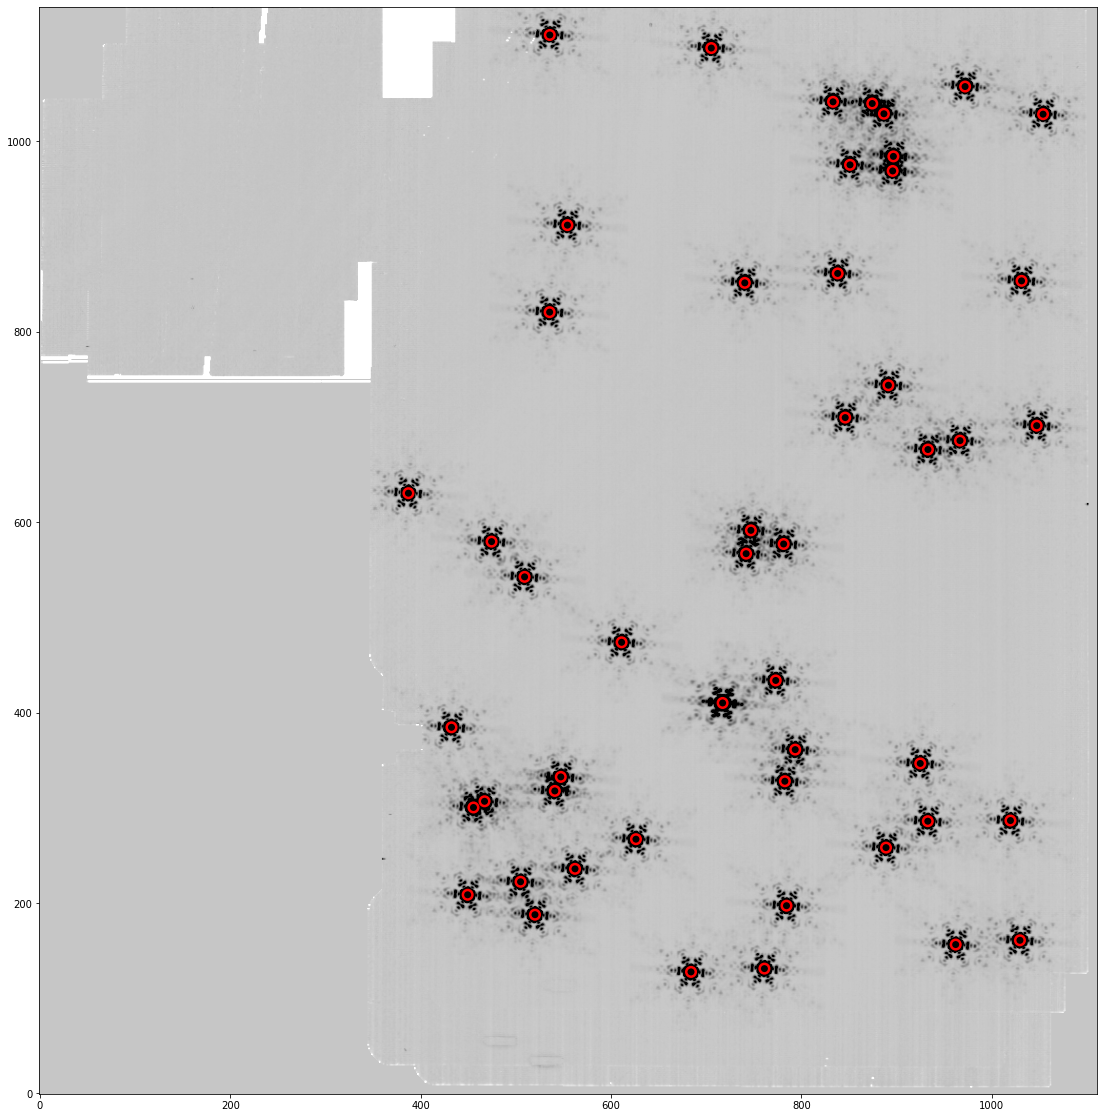

In [11]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='Greys', origin='lower', vmin=-5,vmax=10)#, norm=norm)
apertures.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

#### Run photometry on apertures (with a specified annulus for background subtraction)

Set a specified annulus (inner and outer radii for the annulus).

Run photometry on aperture and annuli.

Subtract background values in annulus from aperture photometry.

Output should be a table of photometry values printed to the screen (full table has columns id, xcenter, ycenter, aperture_sum and the added columns annulus_median, aperture_bkg and aperture_sum_bkgsub). You can choose which columns you wish to see printed.

In [12]:
# set values for inner and outer annuli to collect background counts

inner_annulus = 10.
outer_annulus = 15.

# set up annulus for background
background_aper = CircularAnnulus(positions, r_in=inner_annulus, r_out=outer_annulus)

# perform photometry on apertures for targets and background annuli
phot_table = aperture_photometry(im.data, apertures)

# perform background subtraction with outlier rejection
bkg_median = []
bkg_mask = background_aper.to_mask(method='center')
bmask = bkg_mask[0]
for mask in bkg_mask:
    aper_data = bmask.multiply(data)
    aper_data = aper_data[mask.data > 0]
    
    # perform sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)


# do calculations on background regions found in annuli
# Get average background per pixel
phot_table['annulus_median'] = bkg_median
# Get total background in the science aperture (per pixel * area in aperture)
phot_table['aperture_bkg'] = bkg_median * apertures.area
# subtract background in aperture from flux in aperture
phot_table['aperture_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['aperture_bkg']

# put aperture sum in pixel scale
phot_table['scaled_ap_sum_bkgsub'] = phot_table['aperture_sum_bkgsub'] * pixarea

#print(phot_table['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub','scaled_ap_sum_bkgsub'])

phot_table_sub = phot_table['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub','scaled_ap_sum_bkgsub']
phot_table_sub.pprint_all()

   aperture_sum      annulus_median      aperture_bkg    aperture_sum_bkgsub  scaled_ap_sum_bkgsub 
------------------ ------------------ ------------------ ------------------- ----------------------
 38295.89422611219  4.257134914398193 334.35459431034946   37961.53963180184 1.0796398894338049e-08
 38244.69895445357 4.0283730030059814 316.38767580407614   37928.31127864949 1.0786948630763012e-08
 38228.05107598905 3.8971420526504517 306.08082106506265   37921.97025492399 1.0785145220727408e-08
 37799.55263924726 3.9199371337890625 307.87114255113875  37491.681496696125 1.0662769544750198e-08
38463.703457352945  4.167539596557617  327.3177945022495    38136.3856628507  1.084612573667913e-08
 38536.13186319042  3.906189203262329  306.7913826125175   38229.34048057791 1.0872562422363308e-08
 38523.25582503095  4.130064010620117 324.37446886549395   38198.88135616546 1.0863899737437495e-08
 38387.28124142709 3.9098496437072754 307.07887293278617  38080.202368494305 1.0830147004969273e-08


#### Put x, y coordinates into RA and Dec using the wcs information from the files.
The output of the next block of code should be a table showing the x and y centroid positions as well as the associated RA and Dec values.

In [13]:
# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
sources_sub.pprint_all()

# add option to print out list of sources with flux values
outtable = 'sourcelist_phot_rate.txt'
sources.add_column(phot_table['aperture_sum'])
sources.add_column(phot_table['aperture_sum_bkgsub'])
sources.add_column(phot_table['scaled_ap_sum_bkgsub'])

    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 684.0385190057536 127.53242415526266  0.0008801752883290123   -0.014625738156104805
 761.1449545157529 131.00022925094873     359.99852504720866   -0.014311902727130314
 962.0471389492411 156.25966333571154     359.99243237864135   -0.012996691586770588
 1029.534110303912 160.75021428560206      359.9903749826799   -0.012677379967634834
 520.1398881350739  187.6455542021609   0.006067874218095562   -0.013223431715702656
 784.3390539966355  197.0845602078447       359.997991637554   -0.012223018386677484
 449.4215816156796 208.56812586298636   0.008292746249994357   -0.012772148352899075
 504.9824471011027 222.20766968751317   0.006625683023249606   -0.012204377513545873
 562.1942159186176 235.78935113213103   0.004907839324333664    -0.01163393837837392
 888.8725291960566 258.10965078872016      359.9949503507279    -

#### Compare the RA and Dec positions used to create the simulated data to the values found in the output image.
Difference each set of RA and Dec coordinates in both the input list and the found coordinates, taking into account any angles close to 360/0 degrees. If the difference for both the RA and Dec are below a set tolerance, then the positions match. Take the matched positions and convert the differences from degrees to milli arcseconds, and output the RA and Dec positions as well as the differences. 

In [14]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail')

deltara = []
deltadec = []

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            deltara.append(ra_diff)
            deltadec.append(dec_diff)

            if ra_diff < 30 and dec_diff < 30: 
                test = 'pass' 
            else: 
                test = 'fail'
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f} {:15.5e} {}'.format(ra[j], dec[j], ra_diff, dec_diff, 
                                                                        phot_table['scaled_ap_sum_bkgsub'][j], test))

       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail
     359.998765        0.013802        3.037872        4.667036     1.08572e-08 pass
     359.997498        0.013858        5.144559        7.211353     1.10324e-08 pass
       0.000287       -0.000998        0.390074        7.373490     1.08053e-08 pass
       0.006626       -0.012204        2.458884        5.840951     1.08301e-08 pass
     359.998525       -0.014312        7.369951        3.249818     1.07869e-08 pass
     359.998152       -0.007171        8.627356        5.362007     1.08221e-08 pass
       0.007357       -0.002371        1.416706        5.394961     1.08786e-08 pass
     359.997480        0.003665        0.039481       11.470724     1.07094e-08 pass
       0.008521       -0.001329        6.093767        1.457909     1.07525e-08 pass
       0.001096        0.007721        0.386661        0.216316     1.06633e-08 pass
     359.996649        0.011744        0.128003        0.734

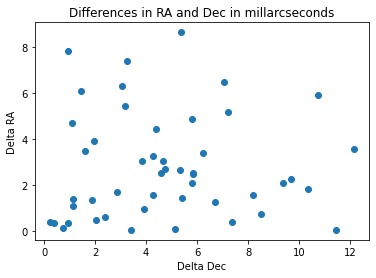

In [15]:
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in millarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltadec,deltara)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds

<a id="residual_ID"></a>
## Compare output RA and Dec to expected values

The output RA and Dec coordinates should match the input RA and Dec coordinates to within 1/10 of a PSF FWHM (~0.03 arcsec for F770W).

Output RA_Diff and Dec_diff above should be on order of 30 or fewer milliarcseconds.

Check to see if your surface brightness is roughly what you expected based on the input data.

[Top of Page](#title_ID)

### Check flux values against spatial coordinates

Another test that can be done is to plot the flux values against x and y values to check for any systmatic patterns. Previous testing has shown a spatial dependence of the flux with y values, such that there is a rise in surface brightness in the middle, and a drop at the image edges. A quick plot can show whether this problem is fixed or not. Prior to the resample step, there is no pattern, after the step, a pattern is clear. Just do this as a last check. If the scatter is not random, there may be a problem that needs to be checked. (Of course, this only works if you give an equivalent if not equal input count level to each input star.) If there is not an obvious rise in the middle (around y centroid pos of 550-600), then this test passes.

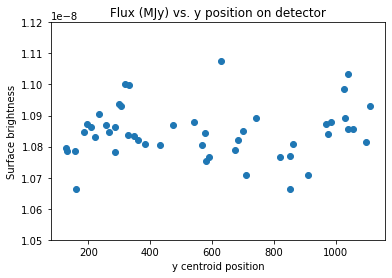

In [16]:
plt.title('Flux (MJy) vs. y position on detector')

plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('y centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['ycentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') 
plt.show()

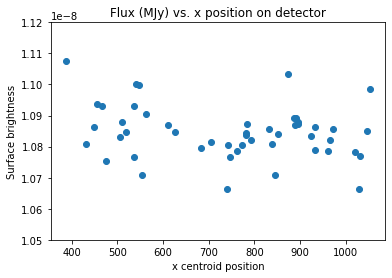

In [17]:
plt.title('Flux (MJy) vs. x position on detector')

plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('x centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['xcentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') #ylim=(30000,40000))
plt.show()

## Repeat prior tests with different scaling factor
Check previous tests with different scaling factor to see if the RA/Dec values still line up and the photometry gives consistent results.

In [18]:
# Grab all *.cal files and create a new association table.
callist = glob.glob('starfield*cal.fits')

# use asn_from_list to create association table
asn = asn_from_list.asn_from_list(callist, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_scaled_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_scaled_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])


In [19]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 5.0  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 50 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom = 'shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True

ratio = 0.5 # Ratio of input to output pixel scale. A value of 0.5 means the output image would have 4 pixels 
            # sampling each input pixel.
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
#pipe3.tweakreg.skip = True
pipe3.tweakreg.use2dhist = use2dhist
pipe3.resample.pixel_scale_ratio = ratio
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3

image = pipe3.run('starfield_50star4ptdither_scaled_asnfile.json')
print('Image 3 pipeline finished.')

2021-07-27 02:22:25,228 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-07-27 02:22:25,230 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-07-27 02:22:25,232 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-07-27 02:22:25,234 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-07-27 02:22:25,236 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-07-27 02:22:25,238 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-07-27 02:22:25,240 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-07-27 02:22:25,527 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_scaled_asnfile.json',).


2021-07-27 02:22:25,534 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 5.0, 'snr_threshold': 50, 'brightest': 1

2021-07-27 02:22:25,634 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-07-27 02:22:25,639 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-07-27 02:22:25,641 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-07-27 02:22:25,642 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-07-27 02:22:25,644 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-07-27 02:22:26,708 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-07-27 02:22:26,710 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 5.0, 'snr_threshold': 50, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-07-27 02:22:27,003 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:22:27,307 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:22:27,604 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:22:27,918 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:22:28,212 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:22:28,510 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:22:28,812 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2021-07-27 02:22:29,094 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2021-07-27 02:22:29,112 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:29,113 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2021-07-27 02:22:29,113 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-07-27 02:22:29,139 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:22:29,140 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:22:29,163 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:22:29,164 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:22:29,189 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:22:29,190 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:22:29,215 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:22:29,216 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:22:29,241 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:22:29,241 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:22:29,266 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:22:29,267 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:22:29,290 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2021-07-27 02:22:29,291 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2021-07-27 02:22:29,316 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2021-07-27 02:22:29,317 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2021-07-27 02:22:29,317 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:29,318 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:22:29,319 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-07-27 02:22:29.318572


2021-07-27 02:22:29,319 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.2


2021-07-27 02:22:29,320 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:22:29,490 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2021-07-27 02:22:29,494 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:22:29,597 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:29,598 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:22:29,599 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:29,601 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:22:29,602 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -3.57881e-05  YSH: -7.15722e-06


2021-07-27 02:22:29,602 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:29,603 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.000163943   FIT MAE: 0.000146938


2021-07-27 02:22:29,604 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-07-27 02:22:29,631 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/wcs.py:1990: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "



2021-07-27 02:22:29,643 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-07-27 02:22:29,747 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:29,749 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2021-07-27 02:22:29,750 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:29,752 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2021-07-27 02:22:29,753 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 4.36472e-05  YSH: -0.000392782


2021-07-27 02:22:29,753 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:29,754 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00333541   FIT MAE: 0.00223968


2021-07-27 02:22:29,755 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-07-27 02:22:29,794 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:22:30,023 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:30,024 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:22:30,025 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:30,028 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:22:30,028 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 5.21703e-05  YSH: -0.000391226


2021-07-27 02:22:30,029 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:30,029 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00335099   FIT MAE: 0.00224753


2021-07-27 02:22:30,030 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-07-27 02:22:30,069 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-07-27 02:22:30,168 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:30,169 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2021-07-27 02:22:30,170 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:30,172 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2021-07-27 02:22:30,173 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.000250549  YSH: 0.000771126


2021-07-27 02:22:30,174 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:30,174 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00585834   FIT MAE: 0.0046928


2021-07-27 02:22:30,175 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-07-27 02:22:30,214 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:22:30,314 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:30,316 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:22:30,317 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:30,319 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:22:30,320 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.000259352  YSH: 0.000784671


2021-07-27 02:22:30,320 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:30,321 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0058466   FIT MAE: 0.00467273


2021-07-27 02:22:30,321 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-07-27 02:22:30,359 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-07-27 02:22:30,459 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:30,461 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2021-07-27 02:22:30,462 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:30,464 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2021-07-27 02:22:30,465 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 7.67894e-06  YSH: 0.000792184


2021-07-27 02:22:30,465 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:30,466 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00557825   FIT MAE: 0.00432725


2021-07-27 02:22:30,466 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 38 objects.


2021-07-27 02:22:30,505 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-07-27 02:22:30,608 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-07-27 02:22:30,610 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2021-07-27 02:22:30,611 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2021-07-27 02:22:30,613 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2021-07-27 02:22:30,613 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -1.88399e-06  YSH: 0.000801737


2021-07-27 02:22:30,614 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-07-27 02:22:30,614 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00560105   FIT MAE: 0.00435278


2021-07-27 02:22:30,615 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 38 objects.


2021-07-27 02:22:30,654 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:22:30,655 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-07-27 02:22:30.654818


2021-07-27 02:22:30,656 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.336246


2021-07-27 02:22:30,656 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-07-27 02:22:30,892 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-07-27 02:22:31,056 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-07-27 02:22:31,058 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-07-27 02:22:31,114 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:31,115 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-07-27 02:22:31.114623


2021-07-27 02:22:31,116 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:31,116 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-07-27 02:22:31,117 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-07-27 02:22:31,117 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-07-27 02:22:31,118 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:31,119 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-07-27 02:22:38,247 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0109372


2021-07-27 02:22:38,248 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.022236


2021-07-27 02:22:38,249 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0132933


2021-07-27 02:22:38,250 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00937814


2021-07-27 02:22:38,250 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-07-27 02:22:38,251 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00884242


2021-07-27 02:22:38,251 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00383076


2021-07-27 02:22:38,252 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0136089


2021-07-27 02:22:38,252 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:38,253 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-07-27 02:22:38,410 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:38,411 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.812714931864468 [not converted]


2021-07-27 02:22:38,412 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:38,412 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-07-27 02:22:38,413 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8237 (old=0.0109372, delta=10.8127)


2021-07-27 02:22:38,414 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.835 (old=0.022236, delta=10.8127)


2021-07-27 02:22:38,414 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.826 (old=0.0132933, delta=10.8127)


2021-07-27 02:22:38,415 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8221 (old=0.00937814, delta=10.8127)


2021-07-27 02:22:38,415 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8127 (old=0, delta=10.8127)


2021-07-27 02:22:38,416 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8216 (old=0.00884242, delta=10.8127)


2021-07-27 02:22:38,416 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8165 (old=0.00383076, delta=10.8127)


2021-07-27 02:22:38,417 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8263 (old=0.0136089, delta=10.8127)


2021-07-27 02:22:38,417 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:38,418 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-07-27 02:22:38.417912


2021-07-27 02:22:38,418 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:07.303289


2021-07-27 02:22:38,419 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-07-27 02:22:38,432 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-07-27 02:22:38,544 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-07-27 02:22:38,546 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-07-27 02:22:38,550 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 8 inputs


2021-07-27 02:22:39,279 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:40,457 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:41,642 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:43,010 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:44,198 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:45,367 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:46,541 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:47,718 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-07-27 02:22:48,714 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 8 images


2021-07-27 02:22:49,434 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2021-07-27 02:22:50,078 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:51,006 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:51,913 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:52,834 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:53,757 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:54,679 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:55,678 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:56,592 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2021-07-27 02:22:56,823 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:422: RuntimeWarning: overflow encountered in multiply
  t2 = scl1 * blot_deriv + snr1 * err_data



2021-07-27 02:22:56,851 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/jwst/outlier_detection/outlier_detection.py:433: RuntimeWarning: overflow encountered in multiply
  mask_2ndpass = scl2 * blot_deriv + snr2 * err_data



2021-07-27 02:22:58,438 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:22:58,661 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:22:58,906 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:22:59,142 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:22:59,368 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:22:59,602 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:22:59,836 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_a3001_crf.fits


2021-07-27 02:23:00,067 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_a3001_crf.fits


2021-07-27 02:23:00,068 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-07-27 02:23:00,409 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-07-27 02:23:00,411 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 0.5, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-07-27 02:23:00,431 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-07-27 02:23:00,597 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_scaled_combined.fits


2021-07-27 02:23:01,142 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-07-27 02:23:01,689 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:03,140 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:04,581 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:06,013 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:07,446 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:08,881 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:10,310 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:11,740 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:12,465 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-07-27 02:23:13,027 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:14,473 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:15,928 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:17,372 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:18,812 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:20,257 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:21,693 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:23,144 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:24,353 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-07-27 02:23:24,903 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:26,346 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:27,787 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:29,232 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:30,675 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:32,119 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:33,559 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:35,002 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:36,251 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-07-27 02:23:36,905 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:38,394 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:39,843 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:41,291 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:42,733 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:44,187 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:45,637 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:47,085 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (2284, 2221)


2021-07-27 02:23:48,365 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-07-27 02:23:48,367 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021513074 -0.020377467 0.024586227 0.014641830 359.990532872 0.017630216 359.987459719 -0.017389081


2021-07-27 02:23:48,842 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_scaled_combined_i2d.fits


2021-07-27 02:23:48,844 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-07-27 02:23:48,992 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(2284, 2221) from starfield_50star4ptdither_scaled_combined_i2d.fits>,).


2021-07-27 02:23:48,994 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-07-27 02:23:49,012 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-07-27 02:23:49,023 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-07-27 02:23:49,024 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-07-27 02:23:49,025 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-07-27 02:23:49,026 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-07-27 02:23:49,027 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-07-27 02:23:49,068 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-07-27 02:23:51,009 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 1578 sources


2021-07-27 02:23:53,066 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_scaled_combined_cat.ecsv


2021-07-27 02:23:53,176 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_scaled_combined_segm.fits


2021-07-27 02:23:53,179 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_scaled_combined_segm.fits


2021-07-27 02:23:53,180 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-07-27 02:23:53,182 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


In [20]:
# Read in the combined data file and list of coordinates

im2 = ImageModel('starfield_50star4ptdither_scaled_combined_i2d.fits')
#get pixel scale
pixarea2 = im2.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea2)
print('Ratio of pixel area scales: original/new scale', pixarea / pixarea2)

# read in text file with RA and Dec input coordinates
RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

# put RA and Dec into floats
RA_sim = RA_in.astype(float)
Dec_sim = Dec_in.astype(float)


# pull out data portion of input file
data2 = im2.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data2, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 7.1100902380771e-14
Ratio of pixel area scales: original/new scale 4.0


Image mean, median and std 2.010515 0.0 48.151455


In [21]:
# Run DAOStarFinder to find sources in image
pixel_ratio = math.sqrt(pixarea / pixarea2) # ratio of pixel area scales in single dimension (sqrt of area)

ap_radius2 = ap_radius * pixel_ratio  # radius for aperture for centroiding and photometry
print('New aperture radius', ap_radius2)

daofind = DAOStarFinder(fwhm=3.0*pixel_ratio, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources2 = daofind(data2)    
#print(sources2['xcentroid','ycentroid','peak'])   
sources2.pprint_all()

# Create apertures for x,y positions
positions2 = tuple(zip(sources2['xcentroid'], sources2['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures2 = CircularAperture(positions2, r=ap_radius2)


New aperture radius 10.0


 id     xcentroid          ycentroid           sharpness            roundness1              roundness2       npix sky        peak              flux                mag        
--- ------------------ ------------------ ------------------- ---------------------- ----------------------- ---- --- ----------------- ------------------ -------------------
  1 1368.0762967547407 254.97424557345127 0.40196133415341584  -0.024034852044142938    -0.06003559784554584   49 0.0  2846.23681640625  6.177695592513585 -1.9770662613101877
  2 1522.3006714382454 261.98816122947187 0.39123887728593887   -0.01777261619760708    -0.06815977672835966   49 0.0 2794.933349609375  6.054325841572415 -1.9551644770439383
  3  1924.081228691207  312.5458930088541  0.4576289690156436    0.07337280025095086      0.2303789452109907   49 0.0  2835.40576171875  5.329221005996595 -1.8166593276685923
  4  2059.145004807527  321.6908581688347 0.41799880917608195   -0.04608248563070611    -0.08483055264764489   49 0.0 2913.36

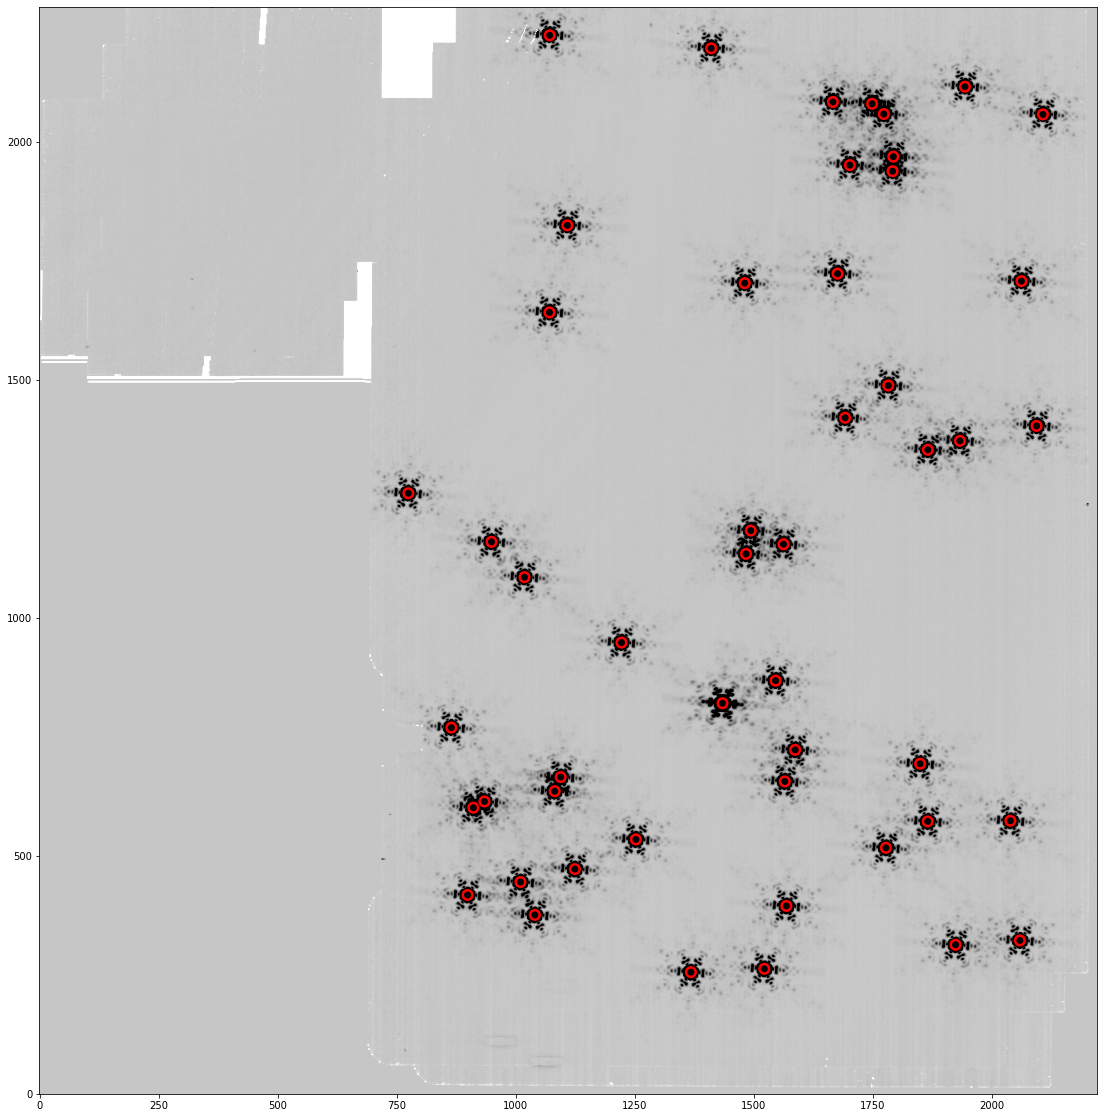

In [22]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data2, cmap='Greys', origin='lower', vmin=-5,vmax=10)#, norm=norm)
apertures2.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

In [23]:
# set values for inner and outer annuli to collect background counts

inner_annulus2 = inner_annulus * pixel_ratio
outer_annulus2 = outer_annulus * pixel_ratio

# set up annulus for background
background_aper2 = CircularAnnulus(positions2, r_in=inner_annulus2, r_out=outer_annulus2)

# perform photometry on apertures for targets and background annuli
phot_table2 = aperture_photometry(im2.data, apertures2)

# perform background subtraction with outlier rejection
bkg_median = []
bkg_mask2 = background_aper2.to_mask(method='center')
bmask2 = bkg_mask2[0]
for mask in bkg_mask2:
    aper_data = bmask2.multiply(data2)
    aper_data = aper_data[mask.data > 0]
    
    # perform sigma-clipped median
    _, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)


# do calculations on background regions found in annuli
# Get average background per pixel
phot_table2['annulus_median'] = bkg_median
# Get total background in the science aperture (per pixel * area in aperture)
phot_table2['aperture_bkg'] = bkg_median * apertures2.area
# subtract background in aperture from flux in aperture
phot_table2['aperture_sum_bkgsub'] = phot_table2['aperture_sum'] - phot_table2['aperture_bkg']
# put aperture sum in pixel scale
phot_table2['scaled_ap_sum_bkgsub'] = phot_table2['aperture_sum_bkgsub'] * pixarea2


In [24]:
phot_table2_sub = phot_table2['aperture_sum','annulus_median','aperture_bkg','aperture_sum_bkgsub','scaled_ap_sum_bkgsub']
phot_table2_sub.pprint_all()

   aperture_sum      annulus_median      aperture_bkg    aperture_sum_bkgsub  scaled_ap_sum_bkgsub 
------------------ ------------------ ------------------ ------------------- ----------------------
154476.36195985525  4.014456272125244 1261.1786332666136  153215.18332658862  1.089373779295571e-08
154456.22709395376  3.955077648162842  1242.524288384558   153213.7028055692 1.0893632526575235e-08
154203.04138921446 3.9423999786376953 1238.5414810400741   152964.4999081744 1.0875913975694562e-08
 152621.7387996329 3.9536190032958984 1242.0660415847394  151379.67275804817 1.0763231335203043e-08
155870.72928947787  3.956536293029785 1242.9825351843767  154627.74675429348   1.09941723273356e-08
154834.31812610495 3.9245734214782715 1232.9411029389896  153601.37702316596 1.0921196513276125e-08
 155257.1499544555  3.955077648162842  1242.524288384558  154014.62566607093 1.0950578864694297e-08
155524.02924757532 3.9245734214782715 1232.9411029389896  154291.08814463633 1.0970235596394722e-08


In [25]:
# using wcs info from images, put coordinates into RA, Dec
ra2, dec2 = im2.meta.wcs(sources2['xcentroid'], sources2['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra2)
dec_col = Column(name='Dec', data=dec2)
sources2.add_column(ra_col)
sources2.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources2['xcentroid', 'ycentroid', 'RA', 'Dec']) 
sources2_sub = sources2['xcentroid', 'ycentroid', 'RA', 'Dec']
sources2_sub.pprint_all()

# add option to print out list of sources with flux values
outtable = 'sourcelist_phot_rate.txt'
sources2.add_column(phot_table2['aperture_sum'])
sources2.add_column(phot_table2['aperture_sum_bkgsub'])
sources2.add_column(phot_table2['scaled_ap_sum_bkgsub'])

    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
1368.0762967547407 254.97424557345127   0.000880193686723694  -0.014627324629895406
1522.3006714382454 261.98816122947187      359.9985249945888  -0.014312273108582314
 1924.081228691207  312.5458930088541     359.99243274340324  -0.012996498133035092
 2059.145004807527  321.6908581688347     359.99037419055657    -0.0126745532178536
 1040.289089152928  375.2778112177615   0.006067842477655326  -0.013223819378623549
1568.6497909517398 394.18472606684986      359.9979922216614  -0.012223013530089035
 898.9605905639601  417.1838207467909   0.008291138747232871  -0.012771457318786091
1009.9701152473052  444.3999722614093   0.006625711235562812  -0.012204802419138409
1124.3938142059676  471.5527825064843   0.004907850864431636  -0.011634524864725127
1777.7533044115023   516.222141642172       359.994950357058  -0.01007053016

In [26]:
# Compare input RA, Dec to found RA, Dec
print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail')

deltara2 = []
deltadec2 = []

for i in np.arange(0,len(RA_sim)):
    for j in np.arange(0,len(ra2)):
        ra_diff = 180 - abs(abs(RA_sim[i] - ra2[j])-180)
        dec_diff = 180 - abs(abs(Dec_sim[i] - dec2[j])-180)

        if ra_diff < 1e-5 and dec_diff < 1e-5:
            # put differences in milliarcseconds
            ra_diff = ra_diff * 3600000
            dec_diff = dec_diff * 3600000
            deltara2.append(ra_diff)
            deltadec2.append(dec_diff)
            if ra_diff < 30 and dec_diff < 30: 
                test = 'pass' 
            else: 
                test = 'fail'
            print('{:15.6f} {:15.6f} {:15.6f} {:15.6f} {:15.6e} {}'.format(ra2[j], dec2[j], ra_diff, dec_diff, 
                                                                        phot_table2['scaled_ap_sum_bkgsub'][j], test))

       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas)  Bkg sub flux  pass/fail
     359.998765        0.013804        3.769107        4.113877    1.099205e-08 pass
     359.997498        0.013857        3.580851        3.390159    1.109458e-08 pass
       0.000287       -0.000999        0.892618        9.685167    1.090632e-08 pass
       0.006626       -0.012205        2.560448        4.311291    1.097024e-08 pass
     359.998525       -0.014312        7.180520        4.583191    1.089363e-08 pass
     359.998151       -0.007171        4.151892        2.966700    1.094841e-08 pass
       0.007357       -0.002374        0.227847       12.657975    1.093892e-08 pass
     359.997480        0.003666        0.171835        7.187147    1.087161e-08 pass
       0.008520       -0.001330        3.361516        3.836284    1.088906e-08 pass
       0.001095        0.007720        5.057112        4.318718    1.084179e-08 pass
     359.996649        0.011744        0.170010        0.596

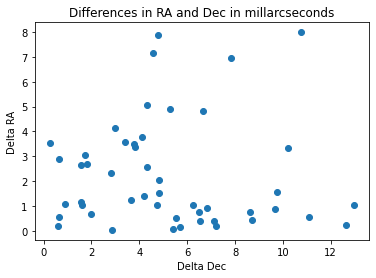

In [27]:
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in millarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltadec2,deltara2)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds

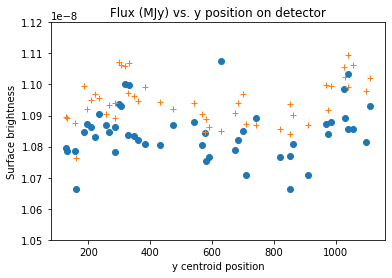

In [28]:
# Compare photometry between the original and scaled images
plt.title('Flux (MJy) vs. y position on detector')
#plt.ylim(33500,39000) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('y centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['ycentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') 
plt.plot(sources2['ycentroid']/2, phot_table2['scaled_ap_sum_bkgsub'], marker='+',linestyle='') 

plt.show()

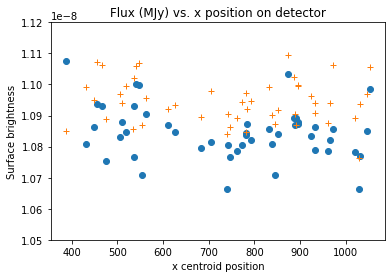

In [29]:
# Compare photometry between the original and scaled images
plt.title('Flux (MJy) vs. x position on detector')
#plt.ylim(33500,39000) # help weed out sources that were erroneously 'hits' (bad pixels, cosmic rays, etc)
plt.ylim(1.05e-08,1.12e-08)
plt.xlabel('x centroid position')
plt.ylabel('Surface brightness')
plt.plot(sources['xcentroid'], phot_table['scaled_ap_sum_bkgsub'], marker='o',linestyle='') 
plt.plot(sources2['xcentroid']/2, phot_table2['scaled_ap_sum_bkgsub'], marker='+',linestyle='') 

plt.show()

In [30]:
# Get some statistics of the two sets of fluxes for comparison
# get stddev from mean for each of the measurements in percentage

photdata1 = phot_table['scaled_ap_sum_bkgsub']
photdata2 = phot_table2['scaled_ap_sum_bkgsub']

std1 = np.std(photdata1)
mean1 = np.mean(photdata1)

std2 = np.std(photdata2)
mean2 = np.mean(photdata2)

per1 = std1 / mean1 * 100
per2 = std2 / mean2 * 100

print('Mean and standard deviation of original scale data', mean1, std1)
print('Mean and standard deviation of new scale data', mean2, std2)

print('The standard deviation from the mean (as a percentage) for the original scale flux data, is', per1)
print('The standard deviation from the mean (as a percentage) for the new scaled flux data, is', per2)

# Compare stats on overall image values, not just phot values

# im is the original scaled image and im2 is the rescaled image

# print stats on original input image
mean1, median1, std1 = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Original image mean, median and std',mean1, median1, std1)

# print stats on rescaled input image
mean2, median2, std2 = sigma_clipped_stats(data2, sigma=200.0, maxiters=5)  # default sigma=3
print('Rescaled image mean, median and std',mean2, median2, std2)

ratio_mean = mean1 / mean2
#ratio_median = median1 / median2

print('The ratio of the mean of the two images is: ', ratio_mean)
#print('The ratio of the median of the two images is: ', ratio_median)

Mean and standard deviation of original scale data 1.103063097120413e-08 1.30029806379906e-09
Mean and standard deviation of new scale data 1.1141503387083602e-08 1.3792553204636e-09
The standard deviation from the mean (as a percentage) for the original scale flux data, is 11.788066042582116
The standard deviation from the mean (as a percentage) for the new scaled flux data, is 12.379436352032863
Original image mean, median and std 1.9922261 0.0 46.595367


Rescaled image mean, median and std 2.010515 0.0 48.151455
The ratio of the mean of the two images is:  0.9909034


### Passing criteria
If all RA/Dec matches have a 'pass' in the table for both original and scaled images, the fluxes for both the original data set and the scaled data set are roughly equal and the mean fluxes are nearly equivalent, then the notebook passes. The ratio printed of the means of the two images should be approximately 1.

<a id="about_ID"></a>
## About this Notebook
**Author:** M. Cracraft, Senior Staff Scientist, INS/MIRI
<br>**Updated On:** 04/02/2021 to add in testing the 'ratio' scaling option in resample.

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 